In [1]:
import chaospy as cp
from chaospy.expansion import stieltjes
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

In [2]:
# Example: 2 Gaussian random variables
dist = cp.J(cp.Normal(0, 1), cp.Normal(0, 1))

# Polynomial basis up to order 2
poly_expansion, _ = stieltjes(order=2, dist=dist, retall=True)

# Define the expansion coefficients c_i(z, t) (example: time-only for now)
def c0(t): return -10*np.exp(-((t-2.5)**2))
def c1(t): return 5*np.sin(t)
def c2(t): return 3*np.cos(t)

# Evaluate the wind shear W(t, ξ) for given ξ
def windshear_pce(t, xi):
    return c0(t) + c1(t)*xi[0] + c2(t)*xi[1]

In [3]:
# Quadrature (Gauss-Hermite or Sparse Grid)
samples = dist.sample(50, rule="halton")  # 50 samples, low-discrepancy

# Generate corresponding wind shear profiles
time_grid = np.linspace(0, 5, 100)
windshear_profiles = np.array([
    [windshear_pce(t, sample) for t in time_grid] for sample in samples.T
])

In [4]:
def solve_ocp(wind_profile, time_grid):
    N = len(time_grid)
    dt = time_grid[1] - time_grid[0]

    x = ca.MX.sym("x", 2)  # state: [altitude, velocity]
    u = ca.MX.sym("u")     # control: pitch angle
    w = ca.MX.sym("w")     # wind shear

    A = ca.Function("A", [x, u, w], [
        ca.vertcat(x[1], -9.81 + u + w)  # simple 1D vertical dynamics
    ])

    # Build integrator
    X = [ca.MX(x)]
    U = []
    for i in range(N-1):
        w_i = wind_profile[i]
        u_i = ca.MX.sym(f"u_{i}")
        U.append(u_i)
        x_next = X[-1] + dt * A(X[-1], u_i, w_i)
        X.append(x_next)

    # Objective: minimize final vertical speed
    obj = ca.sumsqr(X[-1][1])

    # NLP setup
    u_var = ca.vertcat(*U)
    nlp = {'x': u_var, 'f': obj, 'p': X[0]}
    solver = ca.nlpsol('solver', 'ipopt', nlp)
    sol = solver(x0=0.0, p=[0,0])
    return float(sol['x'][0])

In [5]:
controls = [solve_ocp(w, time_grid) for w in windshear_profiles]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4950

Total number of variables............................:       99
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

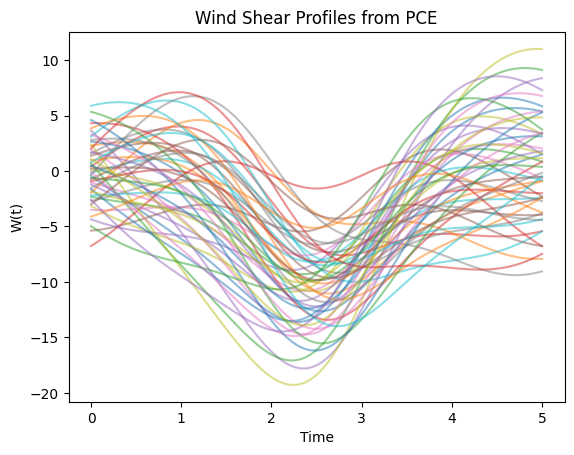

Mean control: 13.40184654574206
Worst-case control: 15.403556186664556


In [6]:
# Plot all wind shear profiles
for profile in windshear_profiles:
    plt.plot(time_grid, profile, alpha=0.5)
plt.title("Wind Shear Profiles from PCE")
plt.xlabel("Time")
plt.ylabel("W(t)")
plt.show()

# Analyze optimal control statistics
print("Mean control:", np.mean(controls))
print("Worst-case control:", np.max(np.abs(controls)))

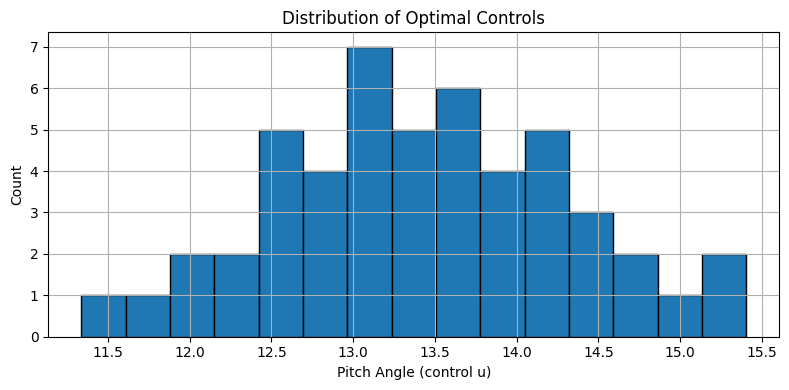

In [7]:
plt.figure(figsize=(8, 4))
plt.hist(controls, bins=15, edgecolor='black')
plt.title("Distribution of Optimal Controls")
plt.xlabel("Pitch Angle (control u)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

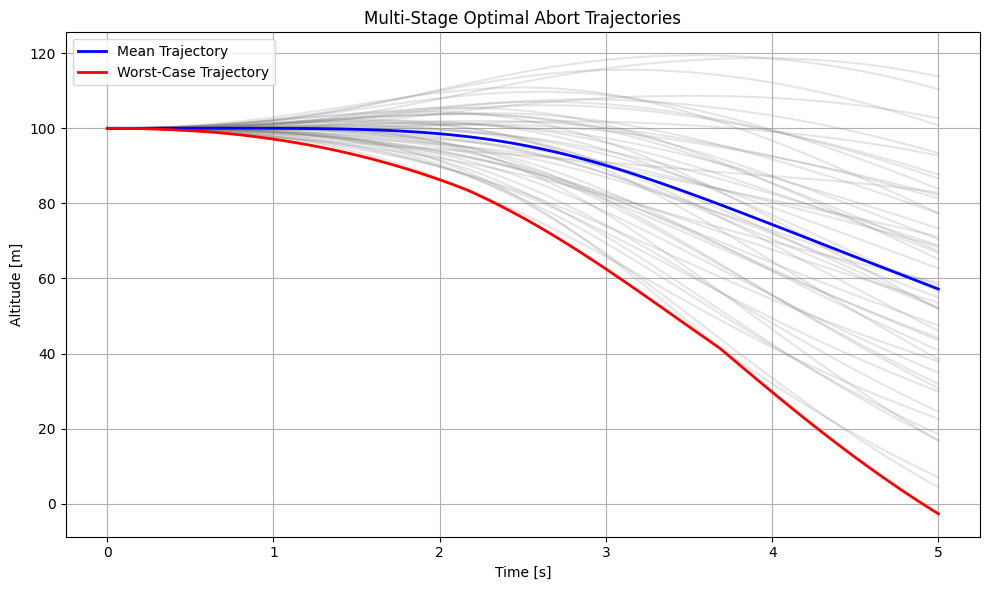

In [8]:
def solve_ocp_multistage(wind_profile, time_grid):
    N = len(time_grid)
    dt = time_grid[1] - time_grid[0]

    # Define decision variables: control input at each time step
    u = ca.MX.sym("u", N)

    # Initialize state
    x = ca.MX([100.0, 0.0])  # initial state: altitude=100m, vertical speed=0
    states = [x]

    # Define dynamics and simulate forward
    for i in range(N-1):
        w_i = wind_profile[i]
        x_dot = ca.vertcat(x[1], -9.81 + u[i] + w_i)
        x = x + dt * x_dot
        states.append(x)

    # Objective: soft landing (zero vertical speed and positive altitude)
    final_state = states[-1]
    obj = final_state[1]**2  # penalty on final vertical speed

    # Add control effort penalty (optional)
    obj += 0.01 * ca.sumsqr(u)

    # Constraints: keep altitude positive throughout
    g = []
    for state in states:
        g.append(state[0])  # altitude > 0

    # Setup NLP
    nlp = {'x': u, 'f': obj, 'g': ca.vertcat(*g)}
    solver = ca.nlpsol('solver', 'ipopt', nlp, {
        'ipopt.print_level': 0,
        'print_time': 0
    })

    # Solve
    u0 = np.zeros(N)
    lbx = -10 * np.ones(N)
    ubx = 10 * np.ones(N)
    lbg = np.zeros(N)
    ubg = 1e5 * np.ones(N)

    sol = solver(x0=u0, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)
    u_opt = sol['x'].full().flatten()

    # Recompute trajectory using optimal u
    x = np.array([100.0, 0.0])
    traj = [x.copy()]
    for i in range(N-1):
        w_i = wind_profile[i]
        x_dot = np.array([x[1], -9.81 + u_opt[i] + w_i])
        x = x + dt * x_dot
        traj.append(x.copy())
    traj = np.array(traj)

    return u_opt, traj

# Apply to all wind shear profiles
control_trajectories = []
state_trajectories = []

for profile in windshear_profiles:
    u_opt, traj = solve_ocp_multistage(profile, time_grid)
    control_trajectories.append(u_opt)
    state_trajectories.append(traj)

# Compute mean/worst-case altitude trajectories
state_trajectories = np.array(state_trajectories)  # shape: (samples, time, 2)
altitudes = state_trajectories[:, :, 0]
mean_altitude = np.mean(altitudes, axis=0)
worst_altitude = np.min(altitudes, axis=0)

# Plot
plt.figure(figsize=(10, 6))
for alt in altitudes:
    plt.plot(time_grid, alt, color='gray', alpha=0.2)
plt.plot(time_grid, mean_altitude, label="Mean Trajectory", color="blue", linewidth=2)
plt.plot(time_grid, worst_altitude, label="Worst-Case Trajectory", color="red", linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Altitude [m]")
plt.title("Multi-Stage Optimal Abort Trajectories")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
